# Functions and Requirements

In [17]:
%matplotlib notebook        
import os
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from camera import test_camera
from camera import take_picture
import numpy as np
from dlib_models import load_dlib_models
load_dlib_models()
from dlib_models import models
face_detect = models["face detect"]
face_rec_model = models["face rec"]
shape_predictor = models["shape predict"]

def numsfromrect(k):
    """
    Given a rectangle k will return x1,y1,x2,y2 of k
    """
    return list(map(int,str(k).replace('(','').replace('[','').replace(')','').replace(']','').replace(',','').split(' ')))

def box_faces(img):
    """
    Draws boxes around all faces in a pic.
    """
    k=face_detect(img)

    fig,ax = plt.subplots()
    ax.imshow(img)

    for i in range(len(k)):
        lst = numsfromrect(k[i])
        ax.add_patch(patches.Rectangle( (lst[0],lst[1]), lst[2]-lst[0], lst[3]-lst[1], fill=False))
        
def get_desc(img):
    """
    Get a single face description from a pic.
    Returns -1 if their is isn't exactly one face.
    
    Used for loading images and labels to avoid bad data.
    """
    k=face_detect(img)
    if len(k)!= 1:
        print("Wrong number of faces detected.")
        return -1
    shape=shape_predictor(img,k[0])
    descv = face_rec_model.compute_face_descriptor(img,shape)
    return np.array(descv)
def eucd(vect1,vect2):
    """
    Euclidian distance of two vectors.
    """
    return np.sqrt(((vect1-vect2)**2).sum())

def descriptions(img):
    """
    Given an image will return the list of descriptions of faces in it.
    """
    faces=face_detect(img)
    lst = []
    for k in faces:
        shape=shape_predictor(img,k)
        descv = face_rec_model.compute_face_descriptor(img,shape)
        lst.append(descv)
    return np.array(lst)
def loadDBimgs(dirt,splt='\\'):
    """
    Loads a db from directory dirt.
    Dirt must be formated like such:
    Folders with names of the desired labels (ie: 'Daschel Cooper')
    Within them .jpg files.
    They will converted to numpy arrays when loaded.
        
    splt = \ in windows
         = / in mac
    """
    lstOfDirs = [x[0] for x in os.walk(dirt)][1:]
    
    db = []
    
    for rootDir in lstOfDirs:
        print(rootDir)
        fileSet = set()

        

        for dir_, _, files in os.walk(rootDir):
            for fileName in files:
                relDir = os.path.relpath(dir_, rootDir)
                relFile = os.path.join(rootDir, fileName)
                if not fileName.startswith('.'):
                    fileSet.add(relFile)
        for file in fileSet:
            img_array = io.imread(file)
            name = rootDir.split(splt)[1]
            db.append((descriptions(img_array)[0], name))
    
    return db

def findMatch(d, db,conf=0.6):
    dists = []
    for i in db:
        dists.append(np.linalg.norm(d-i[0]))
    b = np.argmin(dists)
    print(np.min(dists))
    if(dists[b] < conf):
        return db[b][1]
    else:
        return "I don't know"
    
def label_faces(img,db):
    fig,ax = plt.subplots()
    ax.imshow(img)
    # Number of times to upscale image before detecting faces.
    # When would you want to increase this number?
    upscale = 1

    detections = face_detect(img, upscale)  # returns sequence of face-detections
    detections = list(detections)
    for det in detections:
        # bounding box dimensions for detection
        shape = shape_predictor(img, det)
        descriptor = (np.array(face_rec_model.compute_face_descriptor(img, shape)))
        text = findMatch(descriptor, db)
        lst = numsfromrect(det)
        ax.add_patch(patches.Rectangle( (lst[0],lst[1]), lst[2]-lst[0], lst[3]-lst[1], fill=False))
        ax.text(lst[0], lst[1], text, fontsize=10, color='white')

def saveDBnp(dirt,db,splt='\\'):
    """
    Saves a db to directory dirt.
    
    splt = \ in windows
         = / in mac
    """
    it = 0
    prevname = db[0][1]
    for entr in db:
        ray, name = entr[0],entr[1]
        if name != prevname:
            prevname = name
            it = 0
        direc = dirt + splt + name

        if not os.path.exists(direc):
            os.makedirs(direc)
            
        
        direc = direc + splt +"vct" + str(it)
            
        np.savez(direc,ray=ray)
        it = it + 1
        
def loadDBnp(dirt,splt = '\\'):
    """
    Loads a db from directory dirt.
    Dirt must be formated like such:
    Folders with names of the desired labels (ie: 'Daschel Cooper')
    Within them .npz files storing arrays named 'ray'
        (this naming and format is done automatically by saveDBnp)
        
    splt = \ in windows
         = / in mac
    """
    import skimage.io as io
    import os
    lstOfDirs = [x[0] for x in os.walk(dirt)][1:]
    
    db = []
    
    for rootDir in lstOfDirs:
        print(rootDir)
        fileSet = set()

        

        for dir_, _, files in os.walk(rootDir):
            for fileName in files:
                relDir = os.path.relpath(dir_, rootDir)
                relFile = os.path.join(rootDir, fileName)
                if not fileName.startswith('.'):
                    fileSet.add(relFile)
                    
        for file in fileSet:
            vector = np.load(file)['ray']
            name = rootDir.split(splt)[1]
            db.append( (vector , name) )
    
    return db

def addImgToDB(db,img,label):
    """
    Adds the face vector in img with label 'label' to
    db
    """
    desc = get_desc(img)
    if np.isscalar( desc ) == -1:
        print("error")
        return "early break"
    db.append( (desc,label) )
    return "success"



### Load Vectors

In [18]:
DB = loadDBnp("vectors", splt="/")
DB

vectors/Daschel Cooper
vectors/Dimitris Alexakos
vectors/Henry Bosch
vectors/Lucia Vilallonga
vectors/Manu Varma
vectors/Matthew Callahan
vectors/Robin Williams
vectors/Tom Hanks
vectors/Victor Tao


[(array([-0.09130215,  0.09077848,  0.03475536, -0.02054277, -0.13250671,
          0.04127103, -0.03312144, -0.08453672,  0.08384468, -0.004666  ,
          0.28588754, -0.02264182, -0.262012  , -0.09867485, -0.01900308,
          0.10741461, -0.07745006, -0.14770436,  0.00509068,  0.02118552,
         -0.00595144,  0.01615392,  0.00949688,  0.0397489 , -0.14143005,
         -0.34037396, -0.04920578, -0.03764039, -0.04698876, -0.05266701,
         -0.02051974,  0.15884206, -0.17200327, -0.04958395,  0.07103434,
          0.16249652, -0.06282771, -0.01864635,  0.25708407,  0.06510401,
         -0.11451589, -0.00166452,  0.00969255,  0.31726235,  0.12948366,
          0.01513632,  0.02468036, -0.06353509,  0.07819077, -0.30912846,
          0.07388388,  0.18321267,  0.08180528,  0.0793409 , -0.02643897,
         -0.11187775,  0.0305013 ,  0.10684399, -0.2024186 ,  0.00483036,
         -0.01514347, -0.13127162, -0.04719037, -0.12845364,  0.27203518,
          0.11476175, -0.11557429, -0.

## Take and Label an Image

<IPython.core.display.Javascript object>


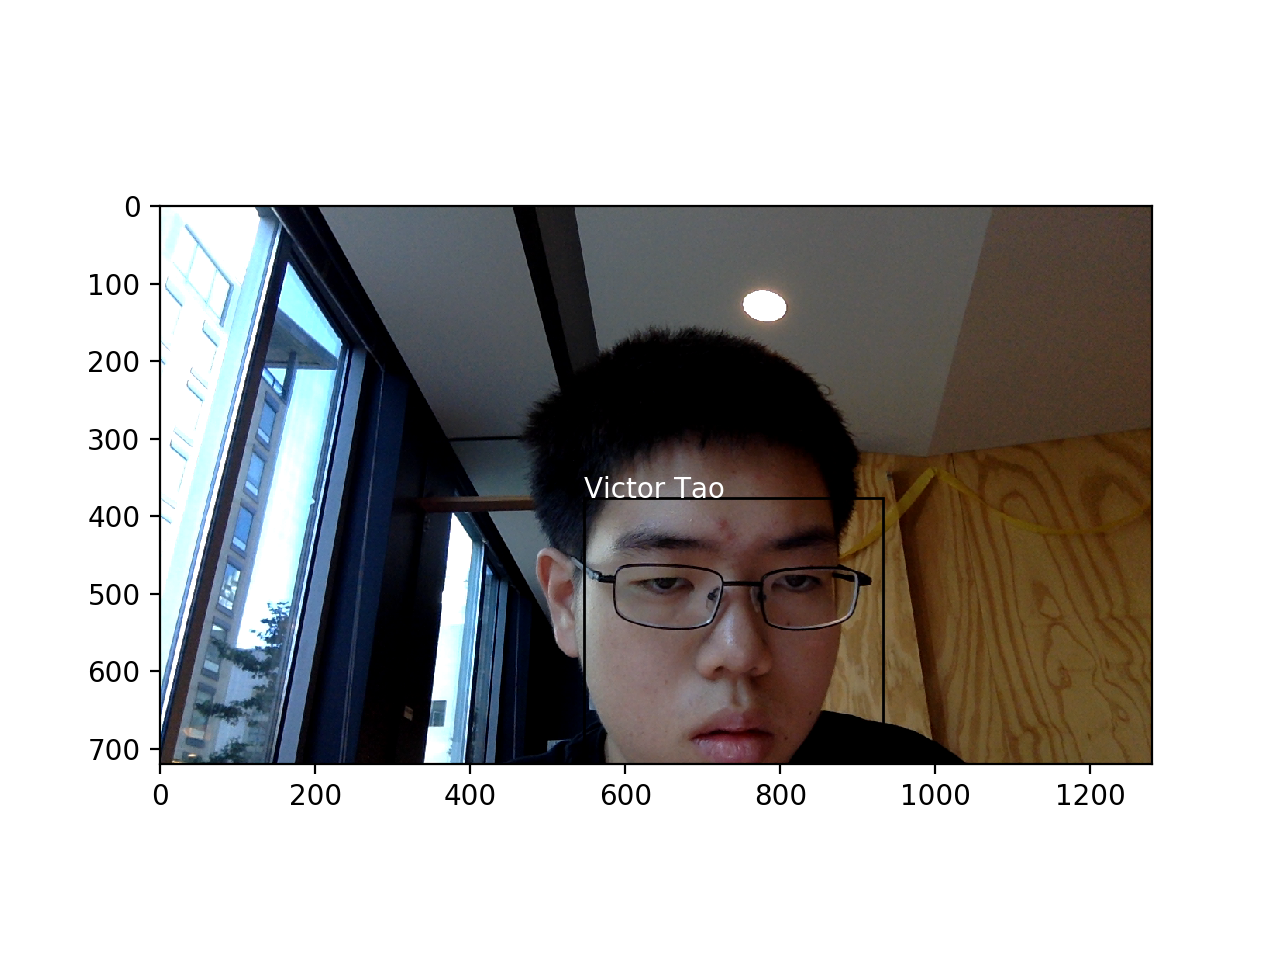

0.423724682055


In [10]:
label_faces(take_picture(),DB)

### Take a picture
Save its vector and add it to DB

In [11]:
name = "Error"

addImgToDB(DB,take_picture(),name)
saveDBnp("vectors",DB)

In [72]:
def cluster(des):
    g = []
    for i in range(len(des)):
        t = []
        for j in range(len(des)):
            #print(np.linalg.norm(j[0]-i[0]))
            if np.linalg.norm(des[i]-des[j]) > 0:
                t.append(np.linalg.norm(des[i]-des[j]) < 0.5)
            else:
                t.append(0)
        g.append(t)
    #print(g)
    c = np.random.permutation(np.arange(len(des)))
    print(c)
    for i in range(100):
        order = np.random.permutation(np.arange(0, len(des)))
        for o in order:
            cl = np.zeros((len(des)))
            for k in range(len(des)):
                cl[c[k]] += g[o][k]
            c[o] = np.argmax(cl)
    return c

In [73]:
desc = []
names = []
for i in DB:
    desc.append(i[0])
    names.append(i[1])
len(desc)

24

In [74]:
c = cluster(desc)

[22  5 13 11 10 19  9 18  2 14 12 21 23 15 17  8  4  7  6 20  1 16  0  3]


In [75]:
list(zip(names, c))

[('Daschel Cooper', 5),
 ('Daschel Cooper', 5),
 ('Daschel Cooper', 5),
 ('Daschel Cooper', 5),
 ('Daschel Cooper', 5),
 ('Dimitris Alexakos', 19),
 ('Dimitris Alexakos', 19),
 ('Henry Bosch', 18),
 ('Henry Bosch', 18),
 ('Lucia Vilallonga', 12),
 ('Lucia Vilallonga', 12),
 ('Manu Varma', 23),
 ('Manu Varma', 23),
 ('Matthew Callahan', 0),
 ('Matthew Callahan', 0),
 ('Matthew Callahan', 7),
 ('Matthew Callahan', 7),
 ('Matthew Callahan', 7),
 ('Robin Williams', 0),
 ('Robin Williams', 0),
 ('Tom Hanks', 1),
 ('Tom Hanks', 1),
 ('Victor Tao', 0),
 ('Victor Tao', 0)]